#### Generowanie losowej próbki danych przy użyciu funkcji sklearn.datasets.make_blobs

In [14]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

features = 4
number_samples = 1000
number_centers = 4
samples, classes = make_blobs(n_samples=number_samples, centers=number_centers, n_features=features, random_state=1)

#### Funkcja obliczająca inertia

In [15]:
def inertia(dists, indicies):
    sum = 0
    for i, dist in enumerate(dists):
        sum += dist[indicies[i]]
    return sum

#### Algorytm k-Means

In [16]:
from scipy.spatial import distance
import numpy as np
def kmeans(P, k, max_iters = 100, min_improvement=0.01):
    prev_dist = 0
    
    while True:
        C = np.random.rand(k, len(P[0])) 
        dists = distance.cdist(P, C, metric='euclidean')
        s2id = np.argmin(dists, axis=1) 
        if len(np.unique(s2id)) == k:
            break #zadbajmy o to aby kazdy centroid mial przynajmniej jeden 'bliski' punkt danych
    
    
    for x in range(max_iters):
        dists = distance.cdist(P, C, metric='euclidean')
        s2id = np.argmin(dists, axis=1) 
        curr_dist = np.mean(np.min(dists, axis=1))
    
        for i in range(len(C)):
            C[i] = np.mean(P[s2id==i], axis=0)
        
        if curr_dist - prev_dist < min_improvement:
            break #jesli nie robimy juz poprawek po co kontyuowac
        
            
        print("Inertia: %s" % inertia(dists, s2id))
            
    return s2id, C

In [17]:
s2id, C = kmeans(samples, k=4, max_iters=20)

Inertia: 10916.946696077519
Inertia: 3378.5256977822605
Inertia: 3341.773762429369
Inertia: 3329.869676710489
Inertia: 3324.749946334778
Inertia: 3322.0543468580404
Inertia: 3320.5616273665073
Inertia: 3319.4879138484866
Inertia: 3318.7287489075006
Inertia: 3318.1451574376956
Inertia: 3317.731432317352
Inertia: 3317.56713026705
Inertia: 3317.4752905987925
Inertia: 3317.4201458479433
Inertia: 3317.3604275800158
Inertia: 3317.33754249061
Inertia: 3317.33754249061
Inertia: 3317.33754249061
Inertia: 3317.33754249061
Inertia: 3317.33754249061


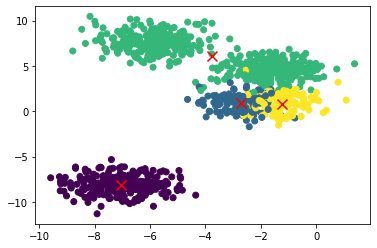

In [18]:
C = np.array(C)
plt.scatter(samples.T[0], samples.T[1], c = s2id)
plt.scatter(C.T[0], C.T[1], s=100, marker='x', c='r')

#### Batchowanie zbioru danych

In [19]:
def batch_dataset(dataset, n_batches):
    batches = np.split(dataset, n_batches)
    return batches

#### Naiwny Mini-batch k-Means (czyli zwykły k-means dla każdego batcha odrębnie)

In [23]:
from numpy import linalg as LA
from sklearn.cluster import KMeans
from scipy.spatial import distance

def sum_sets(C, batch_size, k):
    grouped_C = []
    for i in range(number_centers):
        tmp = []
        for j in range(len(C)):
            tmp.append(C[j][i])
        tmp = np.concatenate(tmp, axis=0)
        np.asmatrix(tmp)
        tmp.shape = (batch_size, k)
        grouped_C.append(tmp.mean(0))
    grouped_C = np.array(grouped_C)
    return grouped_C

def sort_columns(data):
    for i in range(len(data)):
        c = data[i]
        c_sorted = c[np.argsort(c[:,0])]
        data[i] = c_sorted
    return data

def naive_mini_batch_kmeans(dataset,dataset_batches, k=2, max_iters=100, batch_size=1):
    n = len(dataset_batches)
    s2ids = []
    C = []
    for i in range(n):
        batch = dataset_batches[i]
        #result_s2id, result_C = kmeans(batch, k=4)
        kmeans = KMeans(n_clusters=k,max_iter=max_iters, random_state=0).fit(batch)
        s2ids.append(kmeans.labels_)
        C.append(kmeans.cluster_centers_)
        
    C = sort_columns(C)
    grouped_C = sum_sets(C, batch_size, k)
    return s2ids, C, grouped_C

In [24]:
batch_s = 8
dataset_batches = batch_dataset(samples, batch_s)
s2ids, C, grouped_C = naive_mini_batch_kmeans(samples, dataset_batches, k=number_centers, batch_size=batch_s)

#### Surowy wynik z naiwnego

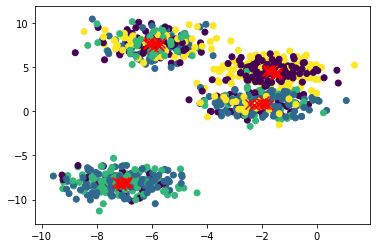

In [25]:
for i in range(len(dataset_batches)):
    plt.scatter(dataset_batches[i].T[0], dataset_batches[i].T[1],c = s2ids[i])
for i in range(len(C)):
    plt.scatter(C[i].T[0], C[i].T[1], s=100, marker='x', c='r')

#### Uśrednione centra (czerwone kulki)

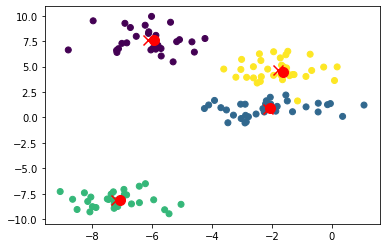

In [26]:
plt.scatter(dataset_batches[1].T[0], dataset_batches[1].T[1], c = s2ids[1])
plt.scatter(C[1].T[0], C[1].T[1],s=100, marker='x', c='r')
for i in range(len(grouped_C)):
    plt.scatter(grouped_C[i].T[0], grouped_C[i].T[1], s=100, marker='o', c='r')

#### Ostateczny wynik naiwnego mini batcha

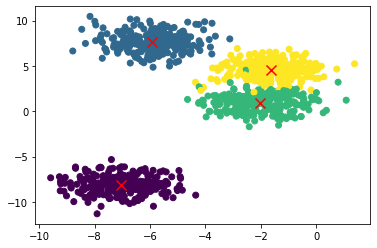

In [27]:
dists = distance.cdist(samples, grouped_C, metric='euclidean')
x = np.argmin(dists, axis=1)
plt.scatter(samples.T[0], samples.T[1], c = x)
plt.scatter(grouped_C.T[0], grouped_C.T[1], s=100, marker='x', c='r')

#### Mini-Batch k-means

In [28]:
from random import randrange
from numpy import linalg as LA
from math import inf
from scipy.spatial import distance
from sklearn.neighbors import KDTree

def compare(L, x):
    for l in L:
        if (l==x).all():
            return True
    return False

def random_picking(dataset, n):
    result = []
    for i in range(n):
        index = randrange(len(dataset))
        sample = dataset[index]
        if compare(result ,sample):
            i -= 1
        else:
            result.append(dataset[index])
    return np.array(result)

def mini_batch_kmeans(dataset,k,batch_size,iterations):  
    
    #C = random_picking(dataset, k) 
    C = dataset[np.random.permutation(dataset.shape[0])[:k]]
    for i in range(iterations):
        #M = random_picking(dataset, batch_size)
        M = dataset[np.random.permutation(dataset.shape[0])[:batch_size]]
        #M = dataset[batch_size*i:batch_size*(i+1)]
        d = {}
        
        V = np.zeros(C.shape[0])
        idxs = np.empty(M.shape[0], dtype=np.int)
        
        for j,x in enumerate(M):
            idxs[j] = np.argmin(((C - x)**2).sum(1))
        
        for j,x in enumerate(M):
            V[idxs[j]] += 1
            lr = 1.0 / V[idxs[j]]
            C[idxs[j]] = (1.0 - lr) * C[idxs[j]] + lr * x
        
        dists = distance.cdist(dataset, C, metric='euclidean')
        s2id = np.argmin(dists, axis=1)
        print("Inertia: %s" % inertia(dists, s2id))
    
    # przygotowanie labelków
    tree = KDTree(C)
    labels = tree.query(dataset, k=1, return_distance=False).squeeze()
    return C, labels
        
        

In [42]:
iterations = 50
batch_size = 50
k = 4
centers, labels = mini_batch_kmeans(samples, k, batch_size, iterations)

Inertia: 3076.656102093274
Inertia: 2014.8194241324336
Inertia: 1920.8327465881412
Inertia: 1974.0074530007394
Inertia: 1972.2594710416322
Inertia: 1929.6266433859982
Inertia: 1918.9378410621657
Inertia: 1913.6684063998027
Inertia: 1968.0667029461142
Inertia: 1944.360573327829
Inertia: 1941.1242718574888
Inertia: 1911.7112129184072
Inertia: 1929.0995034776738
Inertia: 1983.7534815204601
Inertia: 1937.8614738383194
Inertia: 1932.119698298488
Inertia: 1937.829211418968
Inertia: 1926.5823369021823
Inertia: 1902.0030149177317
Inertia: 1943.2672259226006
Inertia: 1923.4907651264675
Inertia: 1939.2156802148552
Inertia: 1930.509930362433
Inertia: 1956.9359835971977
Inertia: 1931.3444210300531
Inertia: 1930.1785894890718
Inertia: 1917.6754322633335
Inertia: 1912.9126705037772
Inertia: 1973.9730014591516
Inertia: 1933.5289864350427
Inertia: 1912.1977232422955
Inertia: 1945.3866919553243
Inertia: 1898.583861237197
Inertia: 1956.9196103086063
Inertia: 1925.5613152485155
Inertia: 1917.553221080598

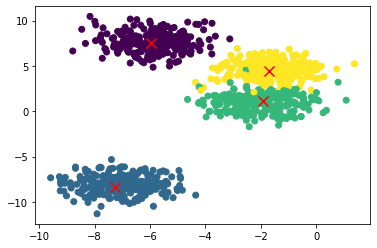

In [43]:
plt.scatter(samples.T[0], samples.T[1], c = labels)
for i in range(len(grouped_C)):
    plt.scatter(centers[i].T[0], centers[i].T[1], s=100, marker='x', c='r')